<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-Catboost" data-toc-modified-id="Модель-Catboost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Модель Catboost</a></span></li><li><span><a href="#Модель-LightGMB" data-toc-modified-id="Модель-LightGMB-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Модель LightGMB</a></span></li><li><span><a href="#Модель-XGBoost" data-toc-modified-id="Модель-XGBoost-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Модель XGBoost</a></span></li></ul></li><li><span><a href="#Сравнение-RMSE-моделей-на-тестовых-выборках" data-toc-modified-id="Сравнение-RMSE-моделей-на-тестовых-выборках-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Сравнение RMSE моделей на тестовых выборках</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Введение

В данном проекте будут построены модели прогнозирования количества заказов такси на следующий час для того, чтобы предсказывать периоды пиковой нагрузки и рассчитывать необходимое количество водителей. Для каждой модели будут рассчитана метрика качества RMSE.

## Подготовка

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(precision=3,suppress=True)
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

Загрузим данные, установим столбец с датой в качестве индекса.

In [22]:
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = [0])

except:
    data = pd.read_csv('C:/Users/Lantana/Documents/data_science/12_time/taxi.csv', parse_dates=[0], index_col = [0])

In [23]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [25]:
data.describe()

,num_orders
count,26496.000
mean,14.070
std,9.211
min,0.000
25%,8.000
50%,13.000
75%,19.000
max,119.000


Проверим, в хронологическом ли порядке расположены дата и время и выполним их ресемплирование по одному часу, т.к. перед нами стоит задача с горизонтом прогнозирования в один час.

In [26]:
data = data.sort_index() 
print(data.index.is_monotonic)

True


In [27]:
data = data.resample('1H').sum()

In [28]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [29]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


***Вывод***

Данные загружены, проверены, произведено ресемплирование по одному часу.

## Анализ

Проанализируем имеющиеся данные: разложим временной ряд на тренд, сезонность и остаток:

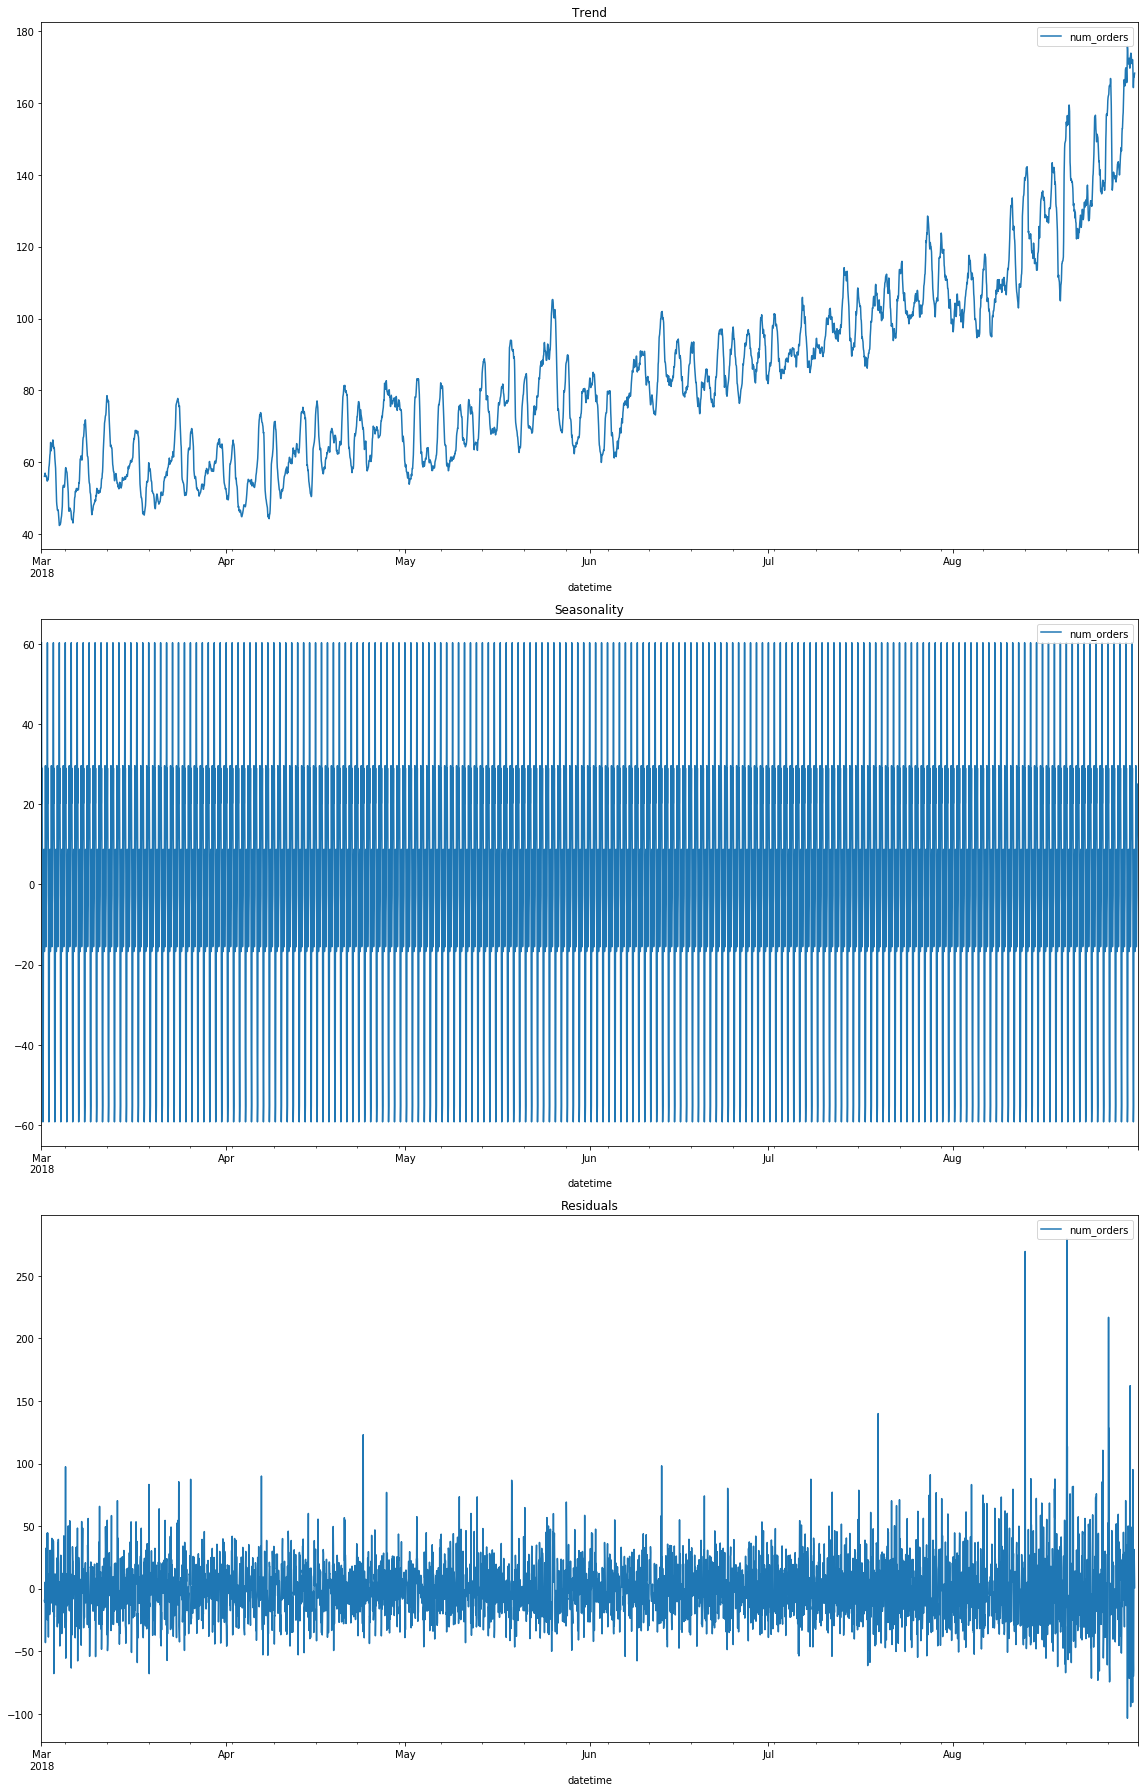

In [30]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 25))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На данных графиках виден тренд на увеличение общего числа заказов, но о сезонности ничего сказать пока нельзя, т.к. слишком много данных. Посмотрим внимательно на данные за одну неделю:

In [31]:
data_short = data['2018-08-25':'2018-08-31']
data_short.head()

,num_orders
datetime,
2018-08-25 00:00:00,273
2018-08-25 01:00:00,246
2018-08-25 02:00:00,160
2018-08-25 03:00:00,187
2018-08-25 04:00:00,196


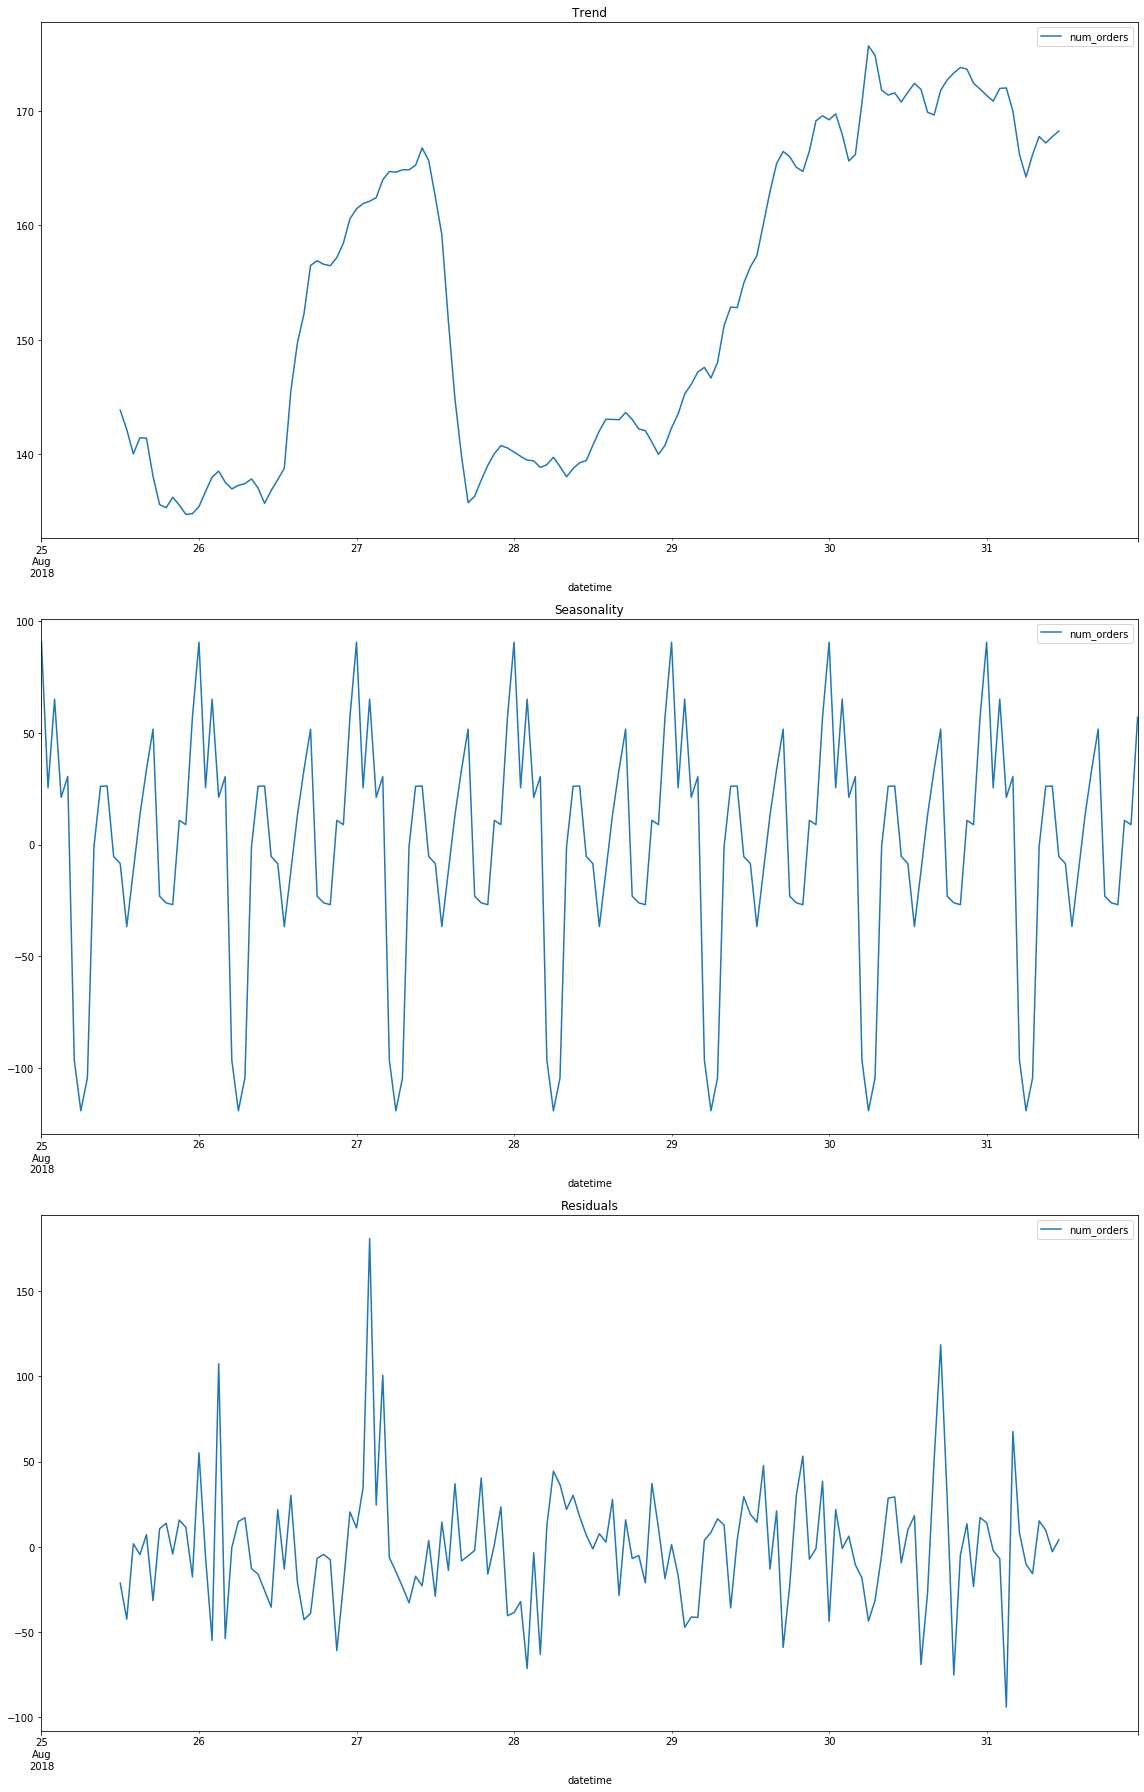

In [32]:
decomposed_short = seasonal_decompose(data_short)

plt.figure(figsize=(16, 25))
plt.subplot(311)

decomposed_short.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed_short.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed_short.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графикам видна 24-часовая сезонность, а также зависимость числа заказов от дня недели.

Построим график за последнюю неделю, применив скользящее среднее:

In [33]:
data_analysis = data_short

Text(0.5, 1.0, 'График числа заказов за последнюю неделю со скользящей средней')

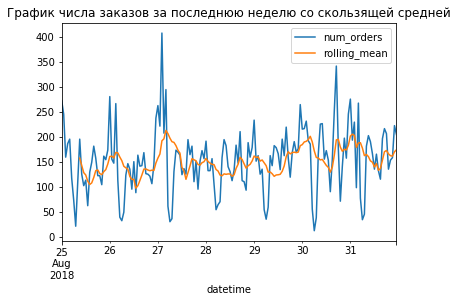

In [34]:
data_analysis['rolling_mean'] = data_analysis.rolling(10).mean()
data_analysis.plot()
plt.title('График числа заказов за последнюю неделю со скользящей средней')

***Вывод***

По графикам выявили 24-часовую сезонность, а также зависимость числа заказов от дня недели, что и будет использовать при дальнейшем построении моделей.

## Обучение

### Создание признаков

Создадим признаки для горизонта прогнозирования в 1 час

Напишем функцию для их создания.

In [35]:
def make_features(data, max_lag, rolling_mean_size):
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Возьмём размер скользящего окна = 7  и параметр max_lag = 24 исходя из дневной сезонности

In [36]:
make_features(data, 24, 7)
display(data.head(10))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 01:00:00,85,3,1,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 02:00:00,71,3,2,85.000,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 03:00:00,66,3,3,71.000,85.000,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 04:00:00,43,3,4,66.000,71.000,85.000,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 05:00:00,6,3,5,43.000,66.000,71.000,85.000,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 06:00:00,12,3,6,6.000,43.000,66.000,71.000,85.000,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2018-03-01 07:00:00,15,3,7,12.000,6.000,43.000,66.000,71.000,85.000,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,58.143
2018-03-01 08:00:00,34,3,8,15.000,12.000,6.000,43.000,66.000,71.000,85.000,124.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,42.571


По исходным данным создадим обучающую (train) и тестовую (test) выборки. Перемешивать выборки в задаче прогнозирования временного ряда нельзя, поэтому установим параметр shuffle=False

In [37]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [38]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [39]:
train = train.dropna()

In [40]:
target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)


### Модель линейной регрессии

In [41]:
model_regr = LinearRegression()
model_regr.fit(features_train, target_train)
predicted_train = model_regr.predict(features_train)
predicted_test= model_regr.predict(features_test)
result_regr = mean_squared_error(target_test, predicted_test) ** 0.5
print("RMSE обучающей выборки для линейной регрессии:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("RMSE тестовой выборки для линейной регрессии: ", result_regr)

RMSE обучающей выборки для линейной регрессии: 25.840672196559467
RMSE тестовой выборки для линейной регрессии:  45.17810654807807


Оценим RMSE кросс-валидацией. Т.к. ряд временной, будем использовать метод TimeSeriesSplit

In [42]:
scores_regression = cross_val_score(model_regr, features_train,target_train, scoring = 'neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=8).split(features_train))
display(scores_regression)
print(f'Средняя оценка rmse модели линейной регрессии методом кросс-валидации: {(sum(scores_regression)/-len(scores_regression)) ** 0.5}')

array([ -502.003,  -586.737,  -569.951,  -652.466,  -631.693,  -711.633,
        -946.617, -1180.346])

Средняя оценка rmse модели линейной регрессии методом кросс-валидации: 26.882721151282002


Построим график для сравения результатов предсказаний реальным тестовым значениям.

In [36]:
predicted_test_data = pd.DataFrame(predicted_test,  columns=['num_orders'], index = test.index)
predicted_test_data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,114.024
2018-08-31 20:00:00,155.181
2018-08-31 21:00:00,185.993
2018-08-31 22:00:00,159.934
2018-08-31 23:00:00,206.647


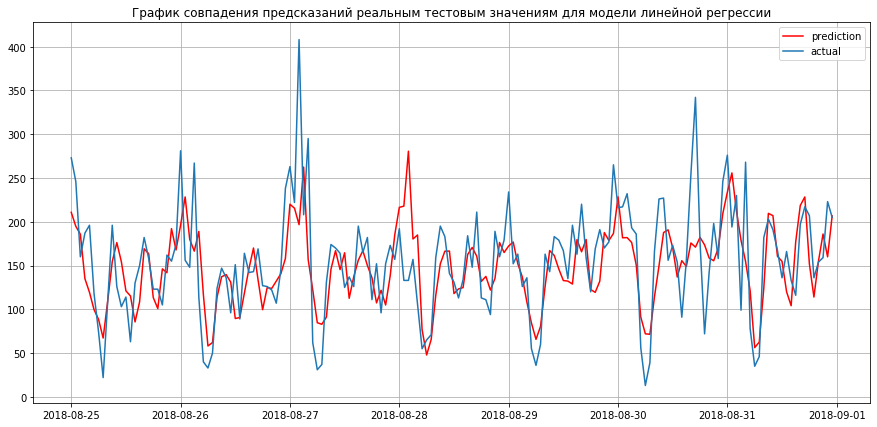

In [37]:
plt.figure(figsize=(15, 7))
plt.plot(predicted_test_data['2018-08-25':'2018-08-31'], "r", label="prediction")
plt.plot(target_test['2018-08-25':'2018-08-31'], label="actual")
plt.legend(loc="best")
plt.title("График совпадения предсказаний реальным тестовым значениям для модели линейной регрессии")
plt.grid(True);

### Модель Catboost

In [24]:
model_cat = CatBoostRegressor(loss_function='RMSE', random_seed=12345, iterations=150)
model_cat.fit(features_train, target_train, verbose=10)

0:	learn: 38.1805717	total: 53.1ms	remaining: 7.91s
10:	learn: 33.5374213	total: 417ms	remaining: 5.27s
20:	learn: 30.2808850	total: 716ms	remaining: 4.4s
30:	learn: 28.1273836	total: 1.01s	remaining: 3.89s
40:	learn: 26.5716164	total: 1.4s	remaining: 3.73s
50:	learn: 25.4625657	total: 1.71s	remaining: 3.31s
60:	learn: 24.6104591	total: 2.1s	remaining: 3.06s
70:	learn: 24.0091329	total: 2.48s	remaining: 2.77s
80:	learn: 23.5285963	total: 2.79s	remaining: 2.37s
90:	learn: 23.2808213	total: 3.08s	remaining: 2s
100:	learn: 22.9903274	total: 3.48s	remaining: 1.69s
110:	learn: 22.7337847	total: 3.96s	remaining: 1.39s
120:	learn: 22.4404545	total: 4.36s	remaining: 1.04s
130:	learn: 22.2458086	total: 4.75s	remaining: 690ms
140:	learn: 22.0811752	total: 5.06s	remaining: 323ms
149:	learn: 21.9199496	total: 5.37s	remaining: 0us


In [25]:
predicted_cat_train = model_cat.predict(features_train)
predictions_cat_test = model_cat.predict(features_test)

In [26]:
result_cat = mean_squared_error(target_test, predictions_cat_test) ** 0.5
print("RMSE обучающей выборки для CatBoost:", mean_squared_error(target_train, predicted_cat_train) ** 0.5)
print("RMSE тестовой выборки для CatBoost: ", result_cat)

RMSE обучающей выборки для CatBoost: 21.91994961922615
RMSE тестовой выборки для CatBoost:  47.5038309456635


Построим график для сравения результатов предсказаний реальным тестовым значениям.

In [38]:
predictions_cat_test_data = pd.DataFrame(predictions_cat_test,  columns=['num_orders'], index = test.index)
predictions_cat_test_data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,102.451
2018-08-31 20:00:00,130.091
2018-08-31 21:00:00,136.725
2018-08-31 22:00:00,132.340
2018-08-31 23:00:00,147.856


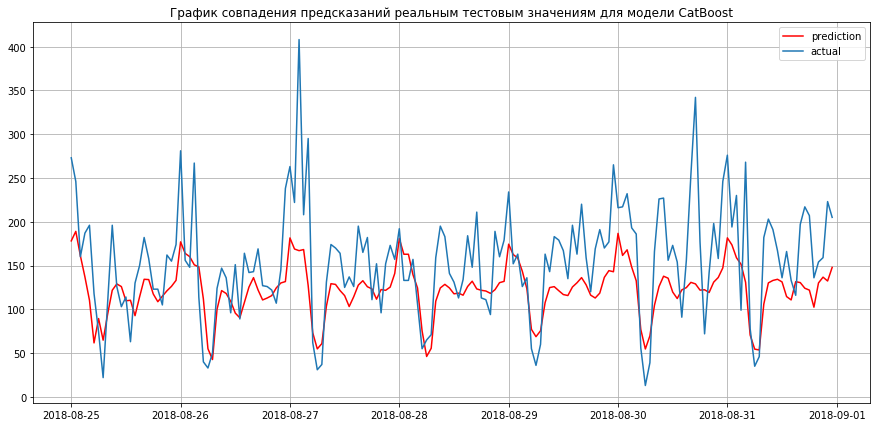

In [39]:
plt.figure(figsize=(15, 7))
plt.plot(predictions_cat_test_data['2018-08-25':'2018-08-31'], "r", label="prediction")
plt.plot(target_test['2018-08-25':'2018-08-31'], label="actual")
plt.legend(loc="best")
plt.title("График совпадения предсказаний реальным тестовым значениям для модели CatBoost")
plt.grid(True);

### Модель LightGMB

In [27]:
model_light = LGBMRegressor(num_leaves = 31, max_depth = -1, random_state=12345, n_estimators=100)
model_light.fit(features_train, target_train, verbose=10)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
predicted_light_train = model_light.predict(features_train)
predictions_light_test = model_light.predict(features_test)

In [29]:
result_light = mean_squared_error(target_test, predictions_light_test) ** 0.5
print("RMSE обучающей выборки для LightGMB:", mean_squared_error(target_train, predicted_light_train) ** 0.5)
print("RMSE тестовой выборки для LightGMB: ", result_light)

RMSE обучающей выборки для LightGMB: 12.405885410041844
RMSE тестовой выборки для LightGMB:  40.56902448945862


Построим график для сравения результатов предсказаний реальным тестовым значениям.

In [40]:
predictions_light_test_data = pd.DataFrame(predictions_light_test,  columns=['num_orders'], index = test.index)
predictions_light_test_data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,131.469
2018-08-31 20:00:00,158.235
2018-08-31 21:00:00,183.191
2018-08-31 22:00:00,162.925
2018-08-31 23:00:00,162.843


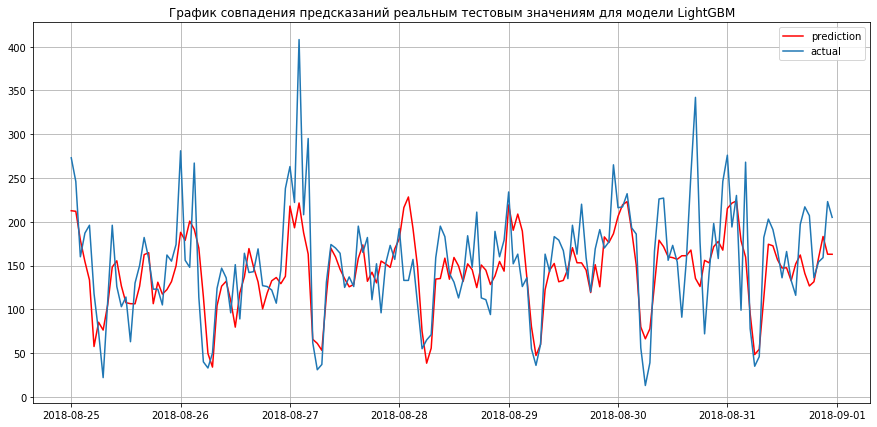

In [41]:
plt.figure(figsize=(15, 7))
plt.plot(predictions_light_test_data['2018-08-25':'2018-08-31'], "r", label="prediction")
plt.plot(target_test['2018-08-25':'2018-08-31'], label="actual")
plt.legend(loc="best")
plt.title("График совпадения предсказаний реальным тестовым значениям для модели LightGBM")
plt.grid(True);

### Модель XGBoost

In [46]:
dtrain = xgb.DMatrix(features_train, label=target_train)
dtest = xgb.DMatrix(features_test)
params = {'objective': 'reg:squarederror', 'booster':'gblinear'}
trees = 100
cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
model_xgb = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

In [31]:
prediction_xgb_train = model_xgb.predict(dtrain)
prediction_xgb_test = model_xgb.predict(dtest)

In [32]:
result_xgb = mean_squared_error(target_test, prediction_xgb_test) ** 0.5
print("RMSE обучающей выборки для XGBoost:", mean_squared_error(target_train, prediction_xgb_train) ** 0.5)
print("RMSE тестовой выборки для XGBoost: ", result_xgb)

RMSE обучающей выборки для XGBoost: 39.5417993920606
RMSE тестовой выборки для XGBoost:  68.97427007918148


<div style="background: #ffeeaa; padding: 5px; border: 1px solid blue; border-radius: 5px;">
<font color='blue'>
Построим график для сравения результатов предсказаний реальным тестовым значениям.

In [42]:
prediction_xgb_test_data = pd.DataFrame(prediction_xgb_test,  columns=['num_orders'], index = test.index)
prediction_xgb_test_data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,78.428
2018-08-31 20:00:00,136.543
2018-08-31 21:00:00,195.729
2018-08-31 22:00:00,166.615
2018-08-31 23:00:00,105.855


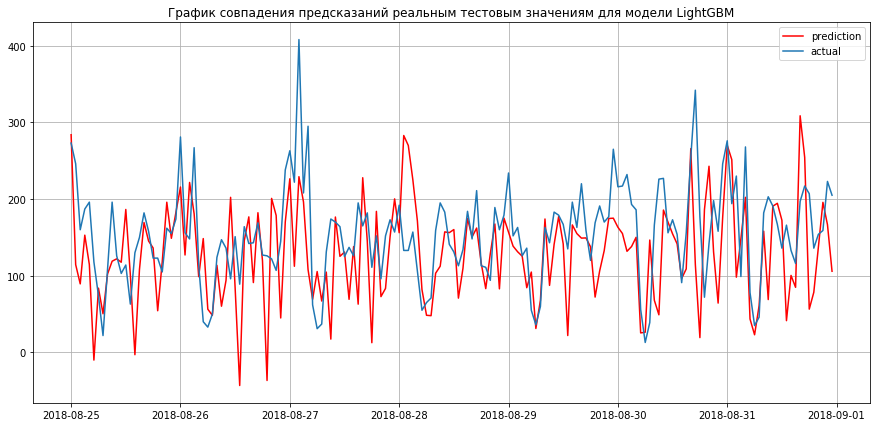

In [43]:
plt.figure(figsize=(15, 7))
plt.plot(prediction_xgb_test_data['2018-08-25':'2018-08-31'], "r", label="prediction")
plt.plot(target_test['2018-08-25':'2018-08-31'], label="actual")
plt.legend(loc="best")
plt.title("График совпадения предсказаний реальным тестовым значениям для модели LightGBM")
plt.grid(True);

## Сравнение RMSE моделей на тестовых выборках

Выведем итоговую таблицу с результатами предсказания на тестовой выборке для рассмотренных моделей.

In [33]:
summary = pd.DataFrame({'model': ['regression', 'CatBoostRegressor', 'LightGMBRegressor', 'XGBoost'], 'RMSE': [result_regr, result_cat, result_light, result_xgb]})
summary

,model,RMSE
0,regression,45.178
1,CatBoostRegressor,47.504
2,LightGMBRegressor,40.569
3,XGBoost,68.974


***Вывод***
По показателям лидирует модель LightGMBRegressor

Модель XGBoost показывает очень плохие результаты предсказаний любых значений, моделям линейной регрессии и LightGMBRegressor удаётся достаточно точно предсказывать даже пиковые значения.

## Общий вывод

В данном проекте были построены модели прогнозирования количества заказов такси на следующий час для того, чтобы предсказывать периоды пиковой нагрузки и рассчитывать необходимое количество водителей. 
Изначально данные были подготовлены, произведено ресемплирование по одному часу.
На основании анализа данных и выводов относительно трендов и сезонности были выбраны параметры лага и скользящего окна.
Были построены модели линейной регрессии, CatBoost, LightGMB, XGBoost.
Для каждой модели рассчитана метрика качества RMSE.
Лидером оказалась модель LightGMBRegressor со значением метрики качества RMSE = 40.6

Модель XGBoost показывает очень плохие результаты предсказаний любых значений, моделям линейной регрессии и LightGMBRegressor удаётся достаточно точно предсказывать даже пиковые значения.